# Geomagnetic Disturbance, Jan 24

On Jan 24th, 2021 there was a pretty good display of Aurora in the sky. I collected data with the RM3100 3-axis magnetometer and Raspberry Pi. Below is a quick analysis of the data to see if it correlates with data from an actual USGS magnetic observatory.

Text(2021-01-24 08:00, 3800, 'Data drift due to sensor movement')

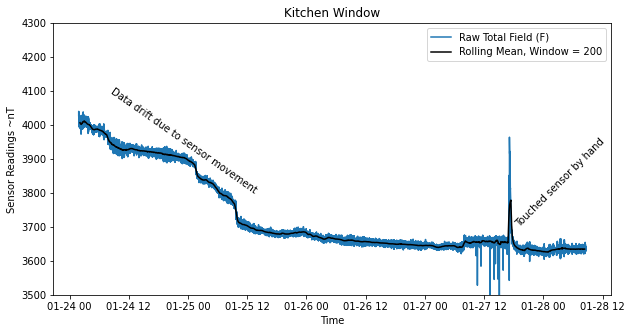

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('magtest_fairbankstrip.txt', parse_dates=[0], header=None, skiprows=3)

df.columns = ['LocalTime', 'F', 'X', 'Y', 'Z']
df.loc[:,'F_mean'] = df['F'].rolling(window=200, center=True).mean()

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 5]
ax.plot(df['LocalTime'], df['F'], label = 'Raw Total Field (F)')
ax.plot(df['LocalTime'], df['F_mean'], color='black', label = 'Rolling Mean, Window = 200')

ax.set_ylim(3500,4300)
#ax.set_xlim('2021-01-09 18:00', '2021-01-11 08:00')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Sensor Readings ~nT')
plt.title('Kitchen Window')
plt.annotate(text='Touched sensor by hand', xycoords='data', xy=['2021-01-27 18:00', 3700], rotation=45)
plt.annotate(text='Data drift due to sensor movement', xycoords='data', xy=['2021-01-24 08:00', 3800], rotation=-35)
#The Raw Total Field should remain relatively flat over the course of several days. Somehow there is a lot of drift
#which I believe is due to the unexpected movement of the sensor from where I positioned it. 
#I found it had moved when we returned home after these four days.


## Let's make some dots...

I'll use these "dots" as a way to flatten out the data while preserving most of the humps and bumps that are likely geomagnetic activity.

In [154]:
#Since I don't know the exact indices of the time stamps, I am searching for the time stamps
#greater than or equal to a time stamp where I want to place a dot. And then I uses .index[0] to 
#get the first one returned and then assign the 'Dots' column to the value I chose, roughly equal to the 
#average at that point.

df.loc[df[df['LocalTime'] >= '2021-01-24 01:51:41'].index[0], 'Dots'] = 4021
df.loc[df[df['LocalTime'] >= '2021-01-25 01:19:57'].index[0], 'Dots'] = 3883
df.loc[df[df['LocalTime'] >= '2021-01-25 01:58:41'].index[0], 'Dots'] = 3849
df.loc[df[df['LocalTime'] >= '2021-01-25 09:25:58'].index[0], 'Dots'] = 3767
df.loc[df[df['LocalTime'] >= '2021-01-25 10:10:15'].index[0], 'Dots'] = 3714
df.loc[df[df['LocalTime'] >= '2021-01-27 07:19:25'].index[0], 'Dots'] = 3640
df.loc[df[df['LocalTime'] >= '2021-01-28 08:37:12'].index[0], 'Dots'] = 3636

In [155]:
df.loc[df['Dots'] > 0]

,LocalTime,F,X,Y,Z,F_mean,Dots
0,2021-01-24 01:51:41,4027.796544,3761,-910,1118,NaN,4021.0
8387,2021-01-25 01:20:04,3879.835692,3750,-983,156,3883.380846,3883.0
8617,2021-01-25 01:58:41,3847.511014,3716,-997,-26,3849.614861,3849.0
11281,2021-01-25 09:26:02,3769.977586,3559,-1075,-625,3767.318985,3767.0
11545,2021-01-25 10:10:21,3710.704920,3449,-1051,-877,3715.204922,3714.0
27678,2021-01-27 07:19:25,3633.142029,3202,-1006,-1391,3640.208403,3640.0
36717,2021-01-28 08:37:14,3636.771370,3109,-1036,-1577,NaN,3636.0


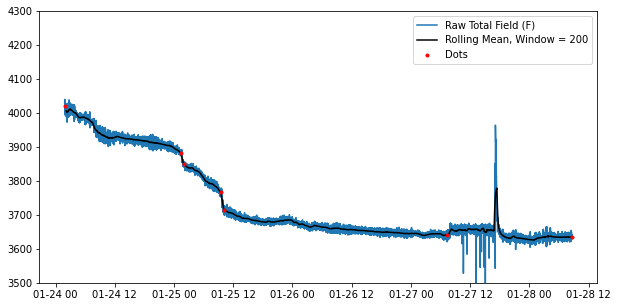

In [156]:
fig1, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 5]
ax1.plot(df['LocalTime'], df['F'], label = 'Raw Total Field (F)')
ax1.plot(df['LocalTime'], df['F_mean'], color='black', label = 'Rolling Mean, Window = 200')
ax1.plot(df['LocalTime'], df['Dots'], marker='.', color='red', linestyle='', label='Dots')

ax1.set_ylim(3500,4300)

plt.legend()


In [157]:
df['Dots'].interpolate(method='linear', inplace = True)

(3500.0, 4300.0)

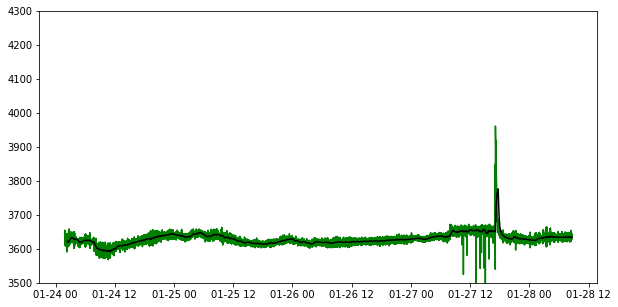

In [160]:
df['CF'] = df['Dots'] - 3636
df['F_Corr'] = df['F'] - df['CF']
df.loc[:, 'F_Corr_Avg'] = df['F_Corr'].rolling(window=200).mean()

fig2, ax2 = plt.subplots()
ax2.plot(df['LocalTime'], df['F_Corr'], color='green', label='Total Field')
ax2.plot(df['LocalTime'], df['F_Corr_Avg'], color='black', label='Rolling Mean, Window = 200')
ax2.set_ylim(3500, 4300)


## Compare with Actual USGS Observatory Data

Use the usgs API to get some data and compare with my data.

In [161]:
import datetime

print(df['LocalTime'].min() + datetime.timedelta(hours=9))
print(df['LocalTime'].max() + datetime.timedelta(hours=9))

2021-01-24 10:51:41
2021-01-28 17:38:34


In [162]:
df_obs = pd.read_csv('https://geomag.usgs.gov/ws/edge/?id=SIT&elements=H,D,Z,F&starttime=2021-01-24T10:51:41&endtime=2021-01-28T17:38:34', 
                     skiprows=21, delim_whitespace=True, parse_dates=[[0,1]], header=None)
df_obs.columns = ['GMTTime', 'DOY', 'SITH', 'SITD', 'SITZ', 'SITF']
df_obs.head()

,GMTTime,DOY,SITH,SITD,SITZ,SITF
0,2021-01-24 10:52:00,24,15760.58,-33.25,52799.26,55188.15
1,2021-01-24 10:53:00,24,15760.47,-33.24,52799.22,55188.07
2,2021-01-24 10:54:00,24,15760.22,-33.23,52799.13,55187.92
3,2021-01-24 10:55:00,24,15759.82,-33.18,52799.00,55187.68
4,2021-01-24 10:56:00,24,15759.73,-33.14,52798.87,55187.54


In [163]:
df_obs['LocalTime'] = df_obs['GMTTime'] - datetime.timedelta(hours=9)
dfresult = pd.merge(df, df_obs, how='outer', on='LocalTime')


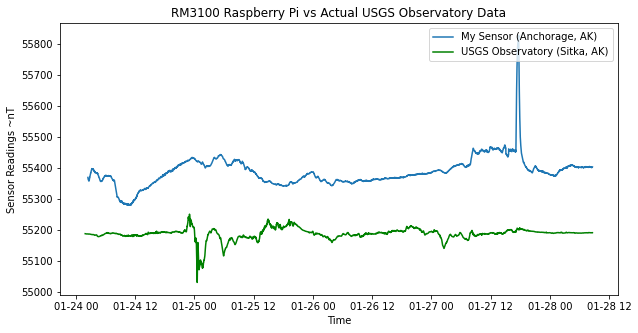

In [178]:
fig, ax = plt.subplots()
ax.plot(dfresult['LocalTime'], dfresult['F_Corr_Avg']*3+44500, label='My Sensor (Anchorage, AK)')
ax.plot(dfresult['LocalTime'], dfresult['SITF'], label='USGS Observatory (Sitka, AK)', color = 'green')
#ax.set_ylim(56300,56500)
plt.xlabel('Time')
plt.ylabel('Sensor Readings ~nT')
plt.title('RM3100 Raspberry Pi vs Actual USGS Observatory Data')
ax.legend(loc='upper right')

## Thoughts...

I still think there is some drift here in the data, exaggerated by the 300% scale factor that I applied. However, I think it is obvious that there is a correlation to the USGS Observatory in Sitka. There are several peaks and valleys that seem to align. I think this confirms that the RM3100 sensor is indeed working. Going forward, I will try to reduce the noise further and invent some sort of permanent fixture.